In [ ]:
# Xin quyen Google drive
from google.colab import drive
drive.mount('/content/ggdrive')

Mounted at /content/ggdrive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**I.Làm sạch và chuẩn bị dữ liệu**

---





In [ ]:
#I.Làm sạch và chuẩn bị dữ liệu
df = pd.read_csv("/content/ggdrive/MyDrive/Phân tích hiệu suất kinh doanh TIMA/test1.csv")

In [ ]:
# Xử lí cột Age bằng cách thay thế bằng trung vị
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
median_age = df['Age'].median()
df['Age'] = df['Age'].fillna(median_age)
df['Age'] = df['Age'].replace(2, median_age)
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

In [ ]:
# Xử lí cột Salary bằng cách thay thế bằng trung vị
df['Salary'] = pd.to_numeric(df['Salary'], errors='coerce')
median_salary = df['Salary'].median()
df['Salary'] = df['Salary'].replace(0, median_salary)
df['Salary'] = pd.to_numeric(df['Salary'], errors='coerce')

In [ ]:
#Xử lí cột LongestOverdue bằng cách thay giá trị âm về 0
df['LongestOverdue'] = pd.to_numeric(df['LongestOverdue'], errors='coerce')
df['LongestOverdue'] = df['LongestOverdue'].apply(lambda x: 0 if x < 0 else x)
df['LongestOverdue'] = pd.to_numeric(df['LongestOverdue'], errors='coerce')

In [ ]:
# Tạo cột mới Thời gian vay
df['FromDate'] = pd.to_datetime(df['FromDate'], errors='coerce')
df['ToDate'] = pd.to_datetime(df['ToDate'], errors='coerce')

# Tạo cột mới LoanDuration bằng cách tính chênh lệch giữa ToDate và FromDate (tính bằng ngày)
df['LoanDuration'] = (df['ToDate'] - df['FromDate']).dt.days

df['LoanDuration'] = df['LoanDuration'].apply(lambda x: 0 if pd.isna(x) or x < 0 else x)

In [ ]:
#Chuyển application date về datetime
df['application_date'] = pd.to_datetime(df['application_date'], errors='coerce')

In [ ]:
df.to_excel('/content/ggdrive/MyDrive/Phân tích hiệu suất kinh doanh TIMA/test2.xlsx', index=False)

In [ ]:
df.to_csv('/content/ggdrive/MyDrive/Phân tích hiệu suất kinh doanh TIMA/test2.csv', index=False)

**II.Khám phá và phân tích dữ liệu**

---



<Axes: xlabel='HasLatePayment', ylabel='count'>

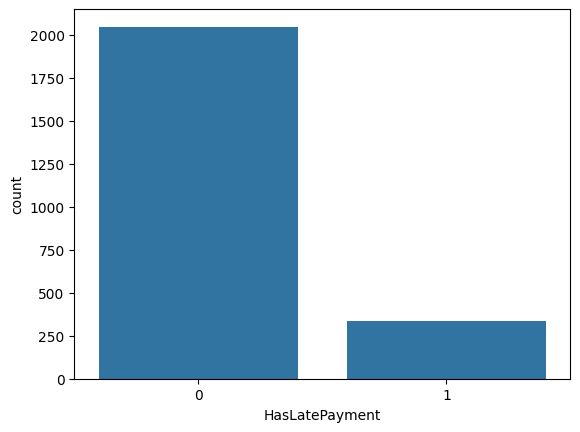

In [ ]:
#II.Khám phá và phân tích dữ liệu
#Khám phá phân bố biến mục tiêu
df['HasLatePayment'].value_counts(normalize=True)
sns.countplot(x='HasLatePayment', data=df)

In [ ]:
#Phân tích mối quan hệ giữa biến đầu vào và HasLatePayment
#a. Biến số (numerical):
sns.boxplot(x='HasLatePayment', y='Salary', data=df)

<Axes: xlabel='HasLatePayment', ylabel='Salary'>

In [ ]:
#b. Biến phân loại (categorical):
pd.crosstab(df['TS_CREDIT_SCORE_V2_class'], df['HasLatePayment'], normalize='index')
sns.countplot(x='TS_CREDIT_SCORE_V2_class', hue='HasLatePayment', data=df)


<Axes: xlabel='TS_CREDIT_SCORE_V2_class', ylabel='count'>

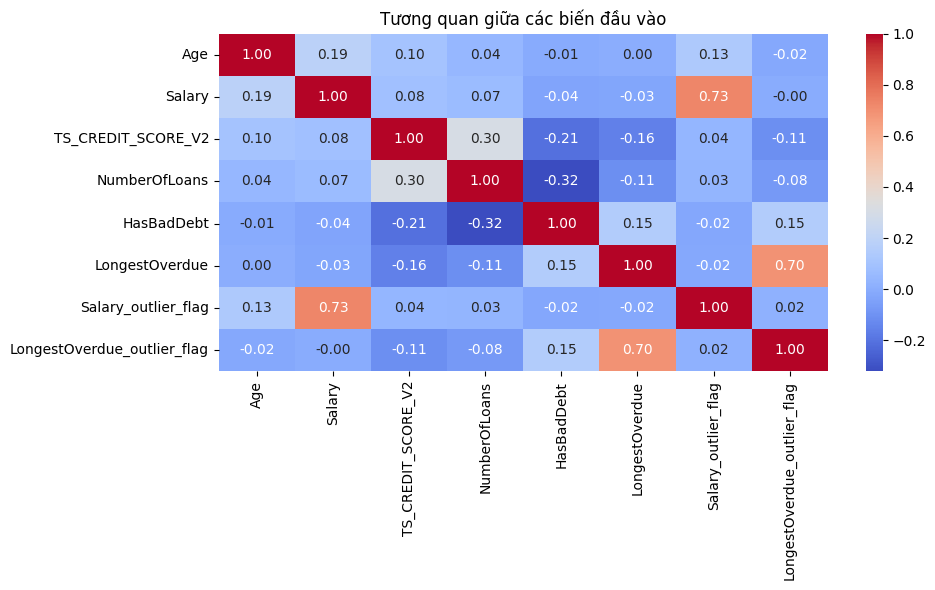

In [ ]:
#Tìm tương quan giữa các biến số
features = [
    'Age', 'Salary', 'TS_CREDIT_SCORE_V2', 'NumberOfLoans',
    'HasBadDebt', 'LongestOverdue', 'Salary_outlier_flag',
    'LongestOverdue_outlier_flag'
]
input_features_df = df[features]

# Tính ma trận tương quan
corr_matrix = input_features_df.corr()

# Vẽ heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Tương quan giữa các biến đầu vào")
plt.tight_layout()
plt.show()

In [ ]:
#Khám phá đặc điểm khách hàng trễ hạn
late_df = df[df['HasLatePayment'] == 1]
late_df['Salary'].describe()
late_df['TS_CREDIT_SCORE_V2_class'].value_counts(normalize=True)

TS_CREDIT_SCORE_V2_class
Tốt        0.508929
TB         0.464286
Nguy cơ    0.017857
Rất Tốt    0.008929
Name: proportion, dtype: float64

In [ ]:
late_df['Age'].value_counts(normalize=True)

Age
29.0    0.116071
28.0    0.077381
32.0    0.068452
31.0    0.068452
25.0    0.065476
35.0    0.053571
24.0    0.053571
30.0    0.050595
37.0    0.047619
34.0    0.044643
27.0    0.041667
43.0    0.038690
38.0    0.038690
26.0    0.035714
33.0    0.035714
41.0    0.029762
42.0    0.023810
36.0    0.023810
40.0    0.020833
39.0    0.008929
51.0    0.008929
23.0    0.008929
54.0    0.005952
49.0    0.005952
22.0    0.005952
44.0    0.005952
58.0    0.002976
53.0    0.002976
50.0    0.002976
60.0    0.002976
52.0    0.002976
Name: proportion, dtype: float64

In [ ]:
late_df['HasBadDebt'].value_counts(normalize=True)

HasBadDebt
0    0.943452
1    0.056548
Name: proportion, dtype: float64

**III.Xây dựng và huấn luyện mô hình**

---



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import joblib
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Hàm xử lý ngày tháng
def parse_date(date_str):
    if pd.isna(date_str) or date_str == 'Unknown' or str(date_str).lower() == 'nan':
        return np.nan
    try:
        # Sử dụng pandas để parse date
        return pd.to_datetime(str(date_str), errors='coerce').timestamp()
    except:
        return np.nan

# Lựa chọn các đặc trưng được yêu cầu
features = [
    'Age',
    'Salary',
    'NumberOfLoans',
    'HasBadDebt',
    'TS_CREDIT_SCORE_V2',
    'Tiền giải ngân',
    'LoanDuration',
    'LongestOverdue',
    'application_date',
    'Salary_outlier_flag',
    'TS_CREDIT_SCORE_V2_class',
    'Trạng thái_encoded'
]

# Biến mục tiêu
target = 'HasLatePayment'

# Kiểm tra các cột có tồn tại không
missing_cols = [col for col in features + [target] if col not in df.columns]
if missing_cols:
    print(f"Các cột không tồn tại trong dữ liệu: {missing_cols}")
    # Loại bỏ các cột không tồn tại
    features = [col for col in features if col in df.columns]
    print(f"Sử dụng các đặc trưng: {features}")

# Kiểm tra biến mục tiêu
if target not in df.columns:
    print(f"Biến mục tiêu '{target}' không tồn tại trong dữ liệu")
    exit()

# Xử lý dữ liệu
print("Đang xử lý dữ liệu...")

# Chuyển đổi application_date thành timestamp
if 'application_date' in features:
    df['application_date'] = df['application_date'].apply(parse_date)

# Mã hóa TS_CREDIT_SCORE_V2_class thành số
if 'TS_CREDIT_SCORE_V2_class' in features:
    credit_score_mapping = {'Rất Tốt': 4, 'Tốt': 3, 'TB': 2, 'Nguy cơ': 1}
    df['TS_CREDIT_SCORE_V2_class'] = df['TS_CREDIT_SCORE_V2_class'].map(credit_score_mapping)

# Xử lý giá trị thiếu theo từng loại dữ liệu
numeric_features = ['Age', 'Salary', 'NumberOfLoans', 'TS_CREDIT_SCORE_V2',
                   'Tiền giải ngân', 'LoanDuration', 'LongestOverdue', 'application_date']
categorical_features = ['HasBadDebt', 'Salary_outlier_flag', 'TS_CREDIT_SCORE_V2_class', 'Trạng thái_encoded']

# Xử lý giá trị thiếu cho numeric features
for col in numeric_features:
    if col in df.columns and col in features:
        df[col] = df[col].fillna(df[col].median())  # Dùng median thay vì mean để tránh outlier

# Xử lý giá trị thiếu cho categorical features
for col in categorical_features:
    if col in df.columns and col in features:
        df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else 0)

# Kiểm tra và loại bỏ các giá trị không hợp lệ
print("Trước khi làm sạch dữ liệu:", df.shape)
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=features + [target])
print("Sau khi làm sạch dữ liệu:", df.shape)

# Kiểm tra phân phối của biến mục tiêu
print(f"\nPhân phối biến mục tiêu '{target}':")
print(df[target].value_counts())
print(f"Tỷ lệ: \n{df[target].value_counts(normalize=True)}")

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X = df[features]
y = df[target]

# Kiểm tra kích thước dữ liệu
if len(X) < 100:
    print("Cảnh báo: Dữ liệu quá ít, có thể ảnh hưởng đến hiệu suất mô hình")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Kích thước tập huấn luyện: {X_train.shape}")
print(f"Kích thước tập kiểm tra: {X_test.shape}")

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Khởi tạo mô hình Logistic Regression
model = LogisticRegression(random_state=42, max_iter=1000)

# Định nghĩa lưới tham số cho Grid Search (đã cải thiện)
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'class_weight': [None, 'balanced']  # Thêm class_weight để xử lý imbalanced data
}

print("Đang tối ưu hóa tham số...")
# Tối ưu hóa tham số bằng Grid Search
grid_search = GridSearchCV(
    model, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1
)
grid_search.fit(X_train_scaled, y_train)

# Lấy mô hình tốt nhất
best_model = grid_search.best_estimator_
print("\n" + "="*50)
print("KẾT QUẢ TỐI ƯU THAM SỐ")
print("="*50)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation F1 score:", round(grid_search.best_score_, 4))

# Dự đoán trên tập kiểm tra
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Đánh giá mô hình
print("\n" + "="*50)
print("ĐÁNH GIÁ MÔ HÌNH TRÊN TẬP KIỂM TRA")
print("="*50)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\n" + "="*60)
print("KẾT QUẢ DỰ ĐOÁN CHI TIẾT TRÊN TẬP KIỂM TRA")
print("="*60)

# Tạo DataFrame kết quả dự đoán
results_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred,
    'Probability_Late': y_pred_proba,
    'Probability_OnTime': 1 - y_pred_proba
})

# Thêm nhãn text cho dễ hiểu
results_df['Actual_Label'] = results_df['Actual'].map({0: 'Không trễ hạn', 1: 'Trễ hạn'})
results_df['Predicted_Label'] = results_df['Predicted'].map({0: 'Không trễ hạn', 1: 'Trễ hạn'})
results_df['Correct'] = (results_df['Actual'] == results_df['Predicted'])

# Hiển thị 20 kết quả đầu tiên
print("20 dự đoán đầu tiên:")
print("-" * 100)
display_cols = ['Actual_Label', 'Predicted_Label', 'Probability_Late', 'Correct']
print(results_df[display_cols].head(20).to_string(index=True))

print(f"\n📊 THỐNG KÊ TỔNG QUAN:")
print(f"- Tổng số dự đoán: {len(results_df)}")
print(f"- Dự đoán đúng: {results_df['Correct'].sum()}")
print(f"- Dự đoán sai: {(~results_df['Correct']).sum()}")
print(f"- Tỷ lệ chính xác: {results_df['Correct'].mean():.1%}")

print(f"\n🎯 PHÂN TÍCH DỰ ĐOÁN:")
correct_not_late = ((results_df['Actual'] == 0) & (results_df['Predicted'] == 0)).sum()
correct_late = ((results_df['Actual'] == 1) & (results_df['Predicted'] == 1)).sum()
wrong_not_late = ((results_df['Actual'] == 0) & (results_df['Predicted'] == 1)).sum()
wrong_late = ((results_df['Actual'] == 1) & (results_df['Predicted'] == 0)).sum()

print(f"✅ Dự đoán đúng 'Không trễ hạn': {correct_not_late}")
print(f"✅ Dự đoán đúng 'Trễ hạn': {correct_late}")
print(f"❌ Dự đoán sai 'Không trễ hạn' thành 'Trễ hạn': {wrong_not_late}")
print(f"❌ Dự đoán sai 'Trễ hạn' thành 'Không trễ hạn': {wrong_late}")

print(f"\n🔥 CÁC TRƯỜNG HỢP RỦI RO CAO (Xác suất trễ hạn > 70%):")
high_risk = results_df[results_df['Probability_Late'] > 0.7]
if len(high_risk) > 0:
    print(f"Số lượng: {len(high_risk)}")
    print(high_risk[['Actual_Label', 'Predicted_Label', 'Probability_Late', 'Correct']].head(10))
else:
    print("Không có trường hợp nào có xác suất > 70%")

print(f"\n🟢 CÁC TRƯỜNG HỢP AN TOÀN (Xác suất trễ hạn < 30%):")
low_risk = results_df[results_df['Probability_Late'] < 0.3]
if len(low_risk) > 0:
    print(f"Số lượng: {len(low_risk)}")
    print(low_risk[['Actual_Label', 'Predicted_Label', 'Probability_Late', 'Correct']].head(10))
else:
    print("Không có trường hợp nào có xác suất < 30%")

# Hiển thị feature importance
print("\n" + "="*50)
print("FEATURE IMPORTANCE")
print("="*50)
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': abs(best_model.coef_[0])
}).sort_values('importance', ascending=False)

print(feature_importance)

# Lưu mô hình và scaler
try:
    joblib.dump(best_model, 'logistic_regression_model.pkl')
    joblib.dump(scaler, 'scaler.pkl')

    # Lưu thêm feature names để sử dụng sau này
    joblib.dump(features, 'feature_names.pkl')

    print("\n" + "="*50)
    print("MÔ HÌNH ĐÃ ĐƯỢC LƯU THÀNH CÔNG")
    print("="*50)
    print("Files saved:")
    print("- logistic_regression_model.pkl")
    print("- scaler.pkl")
    print("- feature_names.pkl")

except Exception as e:
    print(f"Lỗi khi lưu mô hình: {e}")

print("\n" + "="*50)
print("HOÀN THÀNH")
print("="*50)

Đang xử lý dữ liệu...
Trước khi làm sạch dữ liệu: (2383, 51)
Sau khi làm sạch dữ liệu: (2383, 51)

Phân phối biến mục tiêu 'HasLatePayment':
HasLatePayment
0    2047
1     336
Name: count, dtype: int64
Tỷ lệ: 
HasLatePayment
0    0.859001
1    0.140999
Name: proportion, dtype: float64
Kích thước tập huấn luyện: (1906, 12)
Kích thước tập kiểm tra: (477, 12)
Đang tối ưu hóa tham số...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

KẾT QUẢ TỐI ỨU THAM SỐ
Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation F1 score: 0.4393

ĐÁNH GIÁ MÔ HÌNH TRÊN TẬP KIỂM TRA
Accuracy: 0.7547
ROC-AUC Score: 0.8047

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.76      0.84       410
           1       0.33      0.70      0.45        67

    accuracy                           0.75       477
   macro avg       0.63      0.73      0.64       477
weighted avg       0.8